In [4]:
library(BGVAR) #load library
library(ggplot2)
library(zoo)
library(janitor) #rowtonames function


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




## Load Data

In [5]:
# Read in the data files
df_covid = read.csv('../../data/tidy/cases_deaths_concat.csv')
df_google = read.csv('../../data/tidy/google_activity.csv')
df_interv = read.csv('../../data/tidy/govt_interventions.csv')
df_deter = read.csv('../../data/tidy/deterministic.csv')


# Here, we make all the names uniform
# Ideally, this should be done in the preprocessing script in python (make this a TODO)
names(df_covid)[3:(ncol(df_covid))] = gsub(x = names(df_covid)[3:201], pattern = "X", replacement = "")
names(df_google)[3:(ncol(df_google))] = names(df_covid)[3:(ncol(df_covid))]
names(df_interv)[3:(ncol(df_google))] = names(df_covid)[3:(ncol(df_covid))]
df_covid = cbind(df_covid[['iso']], df_covid[['X']], df_covid[,3:(ncol(df_covid))]) #reorder ISO and Variable columns TODO

#Standardize names of first 2 columns (This can/should also be done in python pre-processing script) (TODO)
names(df_covid)[1:2] = c('iso','variable')
names(df_google)[1:2] = c('iso','variable') 
names(df_interv)[1:2] = c('iso','variable')

# Change the variable names to be shorter (TODO)
# Save these new names in the Python pre-processing script. Once this is done, the next few lines should be obsolete
df_interv$variable <- gsub(x = df_interv$variable, pattern = "Public health measures", replacement = "phm")
df_interv$variable <- gsub(x = df_interv$variable, pattern = "Governance and socio-economic measures", replacement = "sem")
df_interv$variable <- gsub(x = df_interv$variable, pattern = "Social distancing", replacement = "sd")
df_interv$variable <- gsub(x = df_interv$variable, pattern = "Movement restrictions", replacement = "mr")
df_interv$variable <- gsub(x = df_interv$variable, pattern = "Lockdown", replacement = "ld")
df_interv$variable <- gsub(x = df_interv$variable, pattern = "Humanitarian exemption", replacement = "he")

#sort all df's by iso: (TODO)
sort_df_by_iso <- function(df) {
    df <- df[order(df[['iso']]), ]
    rownames(df)<-1:nrow(df)
    return(df)
}

df_covid = sort_df_by_iso(df_covid)
df_google = sort_df_by_iso(df_google)
df_interv = sort_df_by_iso(df_interv)
df_deter = sort_df_by_iso(df_deter)

In [6]:
head(df_covid)
head(df_google)
head(df_interv)
head(df_deter)

,iso,variable,2.15.2020,2.16.2020,2.17.2020,2.18.2020,2.19.2020,2.20.2020,2.21.2020,2.22.2020,⋯,8.22.2020,8.23.2020,8.24.2020,8.25.2020,8.26.2020,8.27.2020,8.28.2020,8.29.2020,8.30.2020,8.31.2020
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ARE,cases,8,9,9,9,9,9,9,13,⋯,66617,67007,67282,67621,68020,68511,68901,69328,69690,70231
2,ARE,deaths,0,0,0,0,0,0,0,0,⋯,372,375,376,377,378,378,379,379,382,384
3,ARG,cases,0,0,0,0,0,0,0,0,⋯,336802,342154,350867,359638,370188,380292,392009,401239,408426,417735
4,ARG,deaths,0,0,0,0,0,0,0,0,⋯,6848,6985,7366,7563,7839,8050,8271,8353,8457,8660
5,AUS,cases,15,15,15,15,15,15,15,15,⋯,24811,24915,25053,25204,25322,25448,25547,25670,25746,25819
6,AUS,deaths,0,0,0,0,0,0,0,0,⋯,502,517,525,549,572,583,600,611,652,657


,iso,variable,2.15.2020,2.16.2020,2.17.2020,2.18.2020,2.19.2020,2.20.2020,2.21.2020,2.22.2020,⋯,8.22.2020,8.23.2020,8.24.2020,8.25.2020,8.26.2020,8.27.2020,8.28.2020,8.29.2020,8.30.2020,8.31.2020
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ARE,grocery,4,4,1,1,0,1,2,2,⋯,-9,1,-10,-8,-7,-5,-11,-5,2,-3
2,ARE,parks,5,4,5,5,4,6,6,4,⋯,-43,-37,-42,-41,-41,-42,-55,-46,-38,-40
3,ARE,residential,1,1,1,1,1,1,1,1,⋯,8,22,10,10,10,11,10,8,9,10
4,ARE,retail,0,1,-1,-2,-2,-2,-3,-2,⋯,-23,-19,-25,-24,-23,-22,-30,-23,-18,-21
5,ARE,transit,0,1,1,0,-1,1,0,-2,⋯,-44,-53,-42,-41,-41,-41,-47,-42,-40,-41
6,ARE,workplaces,2,2,2,2,2,1,-1,3,⋯,-15,-58,-20,-21,-20,-20,-13,-11,-21,-22


,iso,variable,2.15.2020,2.16.2020,2.17.2020,2.18.2020,2.19.2020,2.20.2020,2.21.2020,2.22.2020,⋯,8.22.2020,8.23.2020,8.24.2020,8.25.2020,8.26.2020,8.27.2020,8.28.2020,8.29.2020,8.30.2020,8.31.2020
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ARE,mr,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
2,ARE,phm,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
3,ARE,sd,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,ARE,sem,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,ARE,ld,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,ARE,he,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


,iso,year,pop_WDI_PW,gdp_WDI_PW,gdppc_WDI_PW,growth_WDI_PW,pop_WDI,pop_den_WDI,pop_urb_WDI,pop0_14_WDI,workingpop_WDI
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ARE,2015,9156963,3.599900e+11,39313.274,3.7576429,9156963,109.533050,85.54,13.93747,84.92465
2,ARG,2015,43416755,4.559480e+11,10501.660,2.6472714,43416755,15.864696,91.75,25.19420,63.87925
3,AUS,2015,23789752,1.301020e+12,54688.446,2.2400286,23789752,3.096697,89.42,18.69809,66.25704
4,AUT,2015,8638366,4.112190e+11,47603.797,0.9630584,8638366,104.678283,65.96,14.20764,67.03323
5,BEL,2015,11249420,5.082650e+11,45181.438,1.5002308,11249420,371.513210,97.85,16.94444,64.83074
6,BGR,2015,7177991,5.463905e+10,7612.025,3.6174426,7177991,66.120035,73.94,14.14402,65.82851


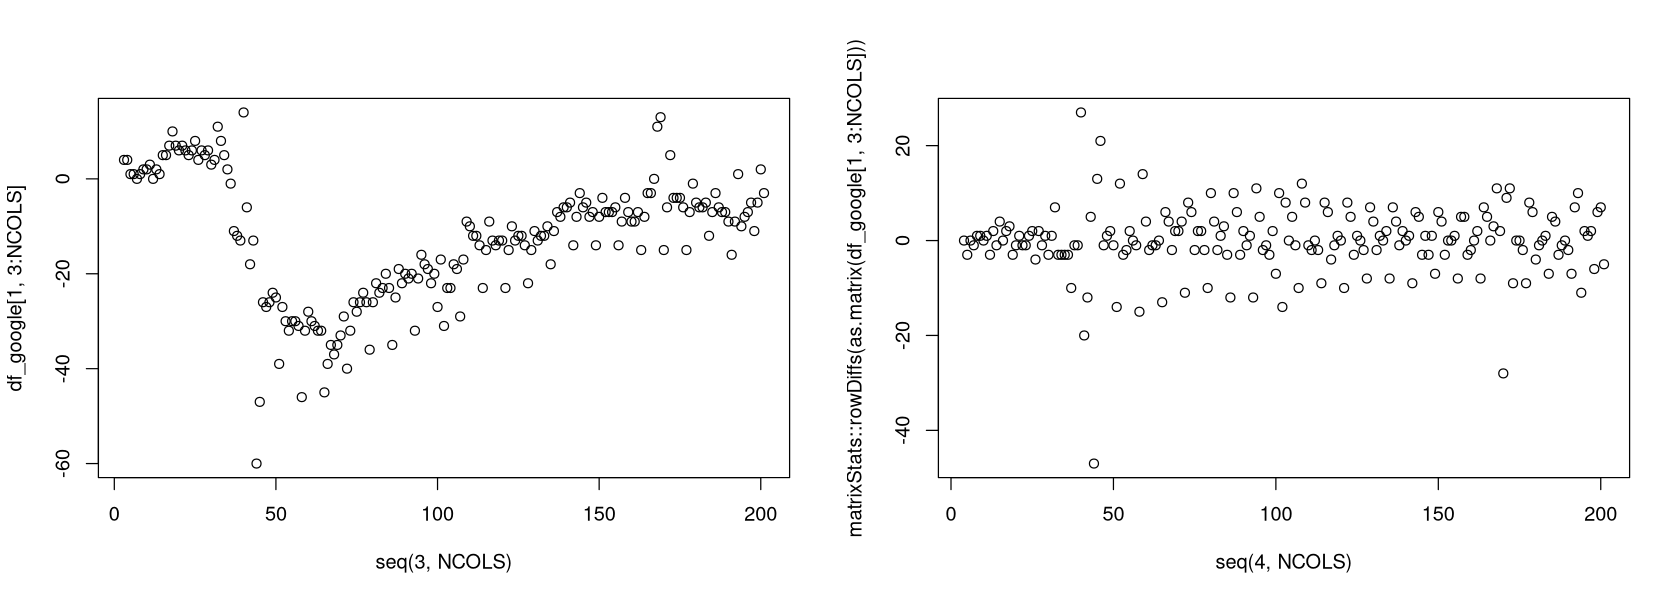

In [8]:
# Exploratory plots for differencing
NCOLS = ncol(df_google)
options(repr.plot.width = 14, repr.plot.height = 5) 
par(mfrow=c(1,2))
plot(seq(3,NCOLS),df_google[1,3:NCOLS]) #quick exploratory plotting
plot(seq(4,NCOLS),matrixStats::rowDiffs(as.matrix(df_google[1,3:NCOLS]))) #quick exploratory plotting

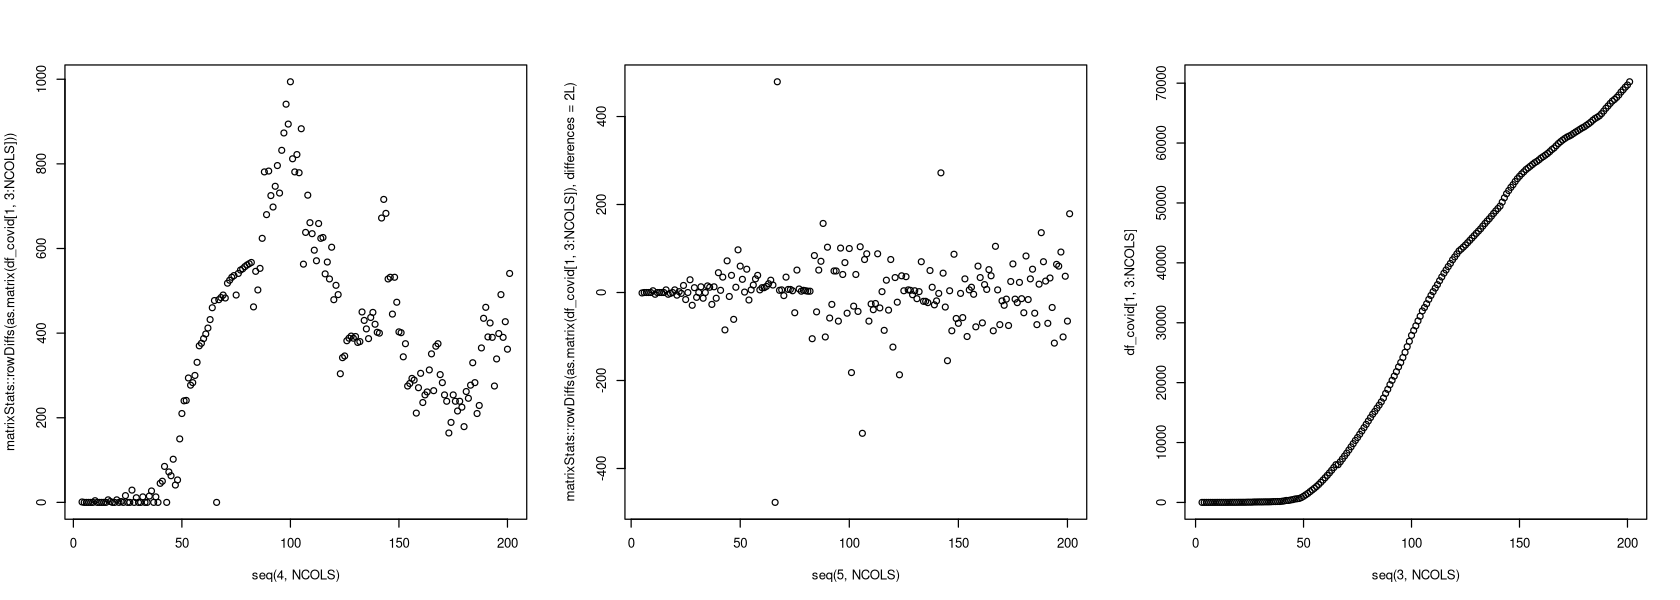

In [9]:
par(mfrow=c(1,3))
plot(seq(4,NCOLS),matrixStats::rowDiffs(as.matrix(df_covid[1,3:NCOLS]))) #quick exploratory plotting
plot(seq(5,NCOLS),matrixStats::rowDiffs(as.matrix(df_covid[1,3:NCOLS]), differences=2L)) # twice differenced
plot(seq(3,NCOLS),df_covid[1,3:NCOLS]) #quick exploratory plotting

In [10]:
# Appropriately difference COVID cases and Google activity data
df_covid[, 5:201] = matrixStats::rowDiffs(as.matrix(df_covid[, 3:201]), differences=2L) # convert to daily cases and then difference
df_google[, 4:201] = matrixStats::rowDiffs(as.matrix(df_google[, 3:201])) # 1st difference of google activity/mobility
# More data transformations can/may need to be done here. 

In [11]:
# Check for consistency/completeness across country names
all(unique(df_google$iso) == unique(df_covid$iso))
all(unique(df_google$iso) == unique(df_interv$iso))
all(unique(df_google$iso) == unique(df_deter$iso))
print(paste0("Number of unique countries: ", length(unique(df_google$iso))))
unique(df_interv$country)[!unique(df_interv$country) %in% unique(df_covid$country)]
unique(df_interv$country)[!unique(df_interv$country) %in% unique(df_google$country)]
unique(df_covid$country)[!unique(df_covid$country) %in% unique(df_google$country)]
unique(df_interv$country)[!unique(df_interv$country) %in% unique(df_deter$iso)]

[1] TRUE

[1] TRUE

[1] TRUE

[1] "Number of unique countries: 57"


NULL

NULL

NULL

NULL

### Convert endogenous data into list of matrices

In [12]:
#Convert endogenous data into list of dataframes; each list element corresponds to country
# For each country, rows = time obs; columns = endogenous variables
df_endo <- rbind(df_covid[,1:NCOLS], df_google[,1:NCOLS]) #endogenous variables
endoList = list()
for (i in unique(df_endo$iso)) {
    country_df = janitor::row_to_names(t(df_endo[df_endo$iso==i, 2:NCOLS]), 1)
    rownames(country_df) <- c()
  #head(b_df)
  endoList[[i]] <- country_df 
}

### Convert exogenous data into list of matrices

In [13]:
df_exo <- df_interv[,1:NCOLS] #strictly exogenous variables
exoList = list()
for (i in unique(df_exo$iso)) {
    country_df = janitor::row_to_names(t(df_exo[df_exo$iso==i, 2:NCOLS]), 1)
    rownames(country_df) <- c()
  #head(b_df)
  exoList[[i]] <- country_df 
}

In [14]:
#Check for consistency across exo and endo countries
names(endoList)
all(names(endoList) == names(exoList))
NCOLS

[1] "ARE" "ARG" "AUS" "AUT" "BEL" "BGR" "BRA" "CAN" "CHE" "CHL" "COL" "CZE"
[13] "DEU" "DNK" "EGY" "ESP" "EST" "FIN" "FRA" "GBR" "GRC" "HRV" "HUN" "IDN"
[25] "IND" "IRL" "ISR" "ITA" "JPN" "KHM" "KOR" "LTU" "LUX" "LVA" "MAR" "MEX"
[37] "MYS" "NLD" "NOR" "NZL" "PHL" "POL" "PRT" "RUS" "SAU" "SGP" "SRB" "SVK"
[49] "SVN" "SWE" "THA" "TUR" "UKR" "URY" "USA" "VNM" "ZAF"

[1] TRUE

[1] 201

### Weight matrix

In [21]:
# Create uniform weight matrix (static in the current implementation)
bW = data.frame(matrix(0, ncol = length(endoList), nrow = length(endoList)))
rownames(bW) = names(endoList)
colnames(bW) = names(endoList)
for ( i in seq(1, length(endoList))) {
  for (j in seq(1, length(endoList))) {
    if (i != j) {
      #print(c(i,j))
      bW[i,j] = 1.0/(length(endoList) - 1)
    }
  }
}

# Check weight matrix structure
all(colnames(bW)==names(endoList))
rowSums(bW)
diag(as.matrix(bW))

# convert matrix into list as required
#bWList = as.matrix(bW)
bWList <- list()
weakly_exo_var_list = c("covid")
for (i in weakly_exo_var_list) {
  bWList[[i]] <- bW
}

for (i in colnames(bW)) {
  w_df <- data.frame(bW[,c(i)])
  colnames(w_df) <- i
  rownames(w_df) <- rownames(bW)
  bWList[[i]] <- w_df
}
#W.list = list()
#bWList = W.list[['covid']]

[1] TRUE

ARE ARG AUS AUT BEL BGR BRA CAN CHE CHL COL CZE DEU DNK EGY ESP EST FIN FRA GBR 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
GRC HRV HUN IDN IND IRL ISR ITA JPN KHM KOR LTU LUX LVA MAR MEX MYS NLD NOR NZL 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
PHL POL PRT RUS SAU SGP SRB SVK SVN SWE THA TUR UKR URY USA VNM ZAF 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1

ARE ARG AUS AUT BEL BGR BRA CAN CHE CHL COL CZE DEU DNK EGY ESP EST FIN FRA GBR 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
GRC HRV HUN IDN IND IRL ISR ITA JPN KHM KOR LTU LUX LVA MAR MEX MYS NLD NOR NZL 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
PHL POL PRT RUS SAU SGP SRB SVK SVN SWE THA TUR UKR URY USA VNM ZAF 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

In [22]:
bWList[['covid']]

,ARE,ARG,AUS,AUT,BEL,BGR,BRA,CAN,CHE,CHL,⋯,SVK,SVN,SWE,THA,TUR,UKR,URY,USA,VNM,ZAF
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARE,0.00000000,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
ARG,0.01785714,0.00000000,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
AUS,0.01785714,0.01785714,0.00000000,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
AUT,0.01785714,0.01785714,0.01785714,0.00000000,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
BEL,0.01785714,0.01785714,0.01785714,0.01785714,0.00000000,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
BGR,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.00000000,0.01785714,0.01785714,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
BRA,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.00000000,0.01785714,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
CAN,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.00000000,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
CHE,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.00000000,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714


In [23]:
#all(names(endoList) == names(bWList))
names(bWList)

[1] "covid" "ARE"   "ARG"   "AUS"   "AUT"   "BEL"   "BGR"   "BRA"   "CAN"  
[10] "CHE"   "CHL"   "COL"   "CZE"   "DEU"   "DNK"   "EGY"   "ESP"   "EST"  
[19] "FIN"   "FRA"   "GBR"   "GRC"   "HRV"   "HUN"   "IDN"   "IND"   "IRL"  
[28] "ISR"   "ITA"   "JPN"   "KHM"   "KOR"   "LTU"   "LUX"   "LVA"   "MAR"  
[37] "MEX"   "MYS"   "NLD"   "NOR"   "NZL"   "PHL"   "POL"   "PRT"   "RUS"  
[46] "SAU"   "SGP"   "SRB"   "SVK"   "SVN"   "SWE"   "THA"   "TUR"   "UKR"  
[55] "URY"   "USA"   "VNM"   "ZAF"

In [28]:
## BGVAR
# SSVS prior
variable.list<-list()
variable.list$covid <-c("cases") #variable.list$fin<-c("stir","ltir","rer")

# Hyperparm.ssvs <- list(tau0   = 0.1,  # coefficients: prior variance for the spike # (tau0 << tau1)
#                        tau1   = 3,    # coefficients: prior variance for the slab  # (tau0 << tau1)
#                        kappa0 = 0.1,  # covariances: prior variance for the spike # (kappa0 << kappa1)
#                        kappa1 = 7,    # covariances: prior variance for the slab # (kappa0 << kappa1)
#                        a_i    = 0.01, # prior for the shape parameter of the IG
#                        b_i    = 0.01, # prior for the scale parameter of the IG
#                        p_i    = 0.5,  # prior inclusion probability of coefficients
#                        q_ij   = 0.5   # prior inclusion probability of covariances
#                       )

model <- bgvar(Data = endoList, #endogenous variables
               Ex = exoList, # exogenous variables
               W = bWList, #WList["covid"], #static weight matrix (use uniform weights) #bWList[c("covid")]
               plag = 7,
               saves=100, burns=100, prior="SSVS", SV=TRUE, #hyperpara=Hyperparm.ssvs, 
               #h = 150, #40% held out 
               thin = 1, 
               variable.list = NULL, #variable.list,
               trend = FALSE,
               save.country.store=FALSE
)

ERROR: Error in bgvar(Data = endoList, Ex = exoList, W = bWList, plag = 7, saves = 100, : unused arguments (saves = 100, burns = 100, variable.list = NULL, save.country.store = FALSE)


In [462]:
bWList

,ARE,ARG,AUS,AUT,BEL,BGR,BRA,CAN,CHE,CHL,⋯,SVK,SVN,SWE,THA,TUR,UKR,URY,USA,VNM,ZAF
ARE,0.00000000,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
ARG,0.01785714,0.00000000,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
AUS,0.01785714,0.01785714,0.00000000,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
AUT,0.01785714,0.01785714,0.01785714,0.00000000,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
BEL,0.01785714,0.01785714,0.01785714,0.01785714,0.00000000,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
BGR,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.00000000,0.01785714,0.01785714,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
BRA,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.00000000,0.01785714,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
CAN,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.00000000,0.01785714,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
CHE,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.00000000,0.01785714,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
CHL,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.00000000,⋯,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714,0.01785714
